In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from skimage.metrics import structural_similarity as ssim
from PIL import Image
from torchvision import transforms

Original images: ['original_1.png', 'original_4.png', 'original_7.png', 'original_8.png']
Reconstructed images: ['recons1.png', 'recons4.png', 'recons7.png', 'recons8.png']
Metrics for original_4.png vs recons4.png:
Metric     | Value          
----------------------------
MSE        | 0.02210824     
RMSE       | 0.14868841     
PSNR       | 16.55445790    
SSIM       | 0.60740260     
MAE        | 0.11007903     


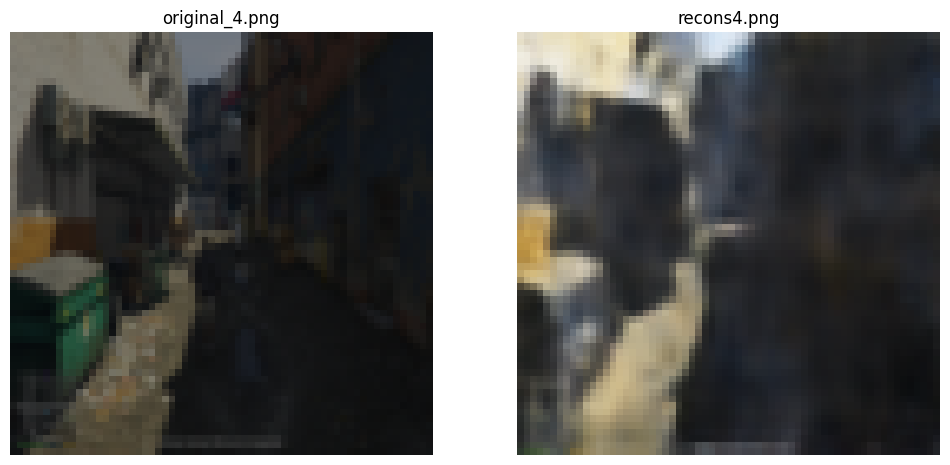

In [22]:


def load_images(folder, prefix):
    """
    Load and preprocess images with a specific prefix from a folder.

    Args:
        folder (str): Path to the folder containing images.
        prefix (str): Prefix to filter images (e.g., 'original', 'recons').

    Returns:
        dict: Dictionary with filenames as keys and preprocessed image tensors as values.
    """
    images = {}
    for filename in sorted(os.listdir(folder)):
        if filename.startswith(prefix) and filename.endswith(('png', 'jpg', 'jpeg')):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).convert('RGB')
            images[filename] = preprocess_image(img)
    return images

def preprocess_image(image):
    """
    Preprocess the image by resizing and normalizing it.
    
    Args:
        image (PIL Image): Input image.
    
    Returns:
        Tensor: Preprocessed image tensor.
    """
    transform = transforms.Compose([
        transforms.Resize((64, 64)),  # Resize to 64x64
        transforms.ToTensor(),       # Convert to tensor
    ])
    return transform(image)

def calculate_metrics(original_tensor, reconstructed_tensor):
    # Convertir tensores a arrays NumPy
    original_np = np.asarray(original_tensor)
    reconstructed_np = np.asarray(reconstructed_tensor)

    # Asegurarse de que las imágenes tengan las mismas dimensiones
    if original_np.shape != reconstructed_np.shape:
        raise ValueError("Original and reconstructed images must have the same dimensions.")

    # Normalizar las imágenes si no están en el rango [0, 1]
    if original_np.max() > 1.0:
        original_np = original_np / 255.0
    if reconstructed_np.max() > 1.0:
        reconstructed_np = reconstructed_np / 255.0

    # Calcular métricas
    mse = np.mean((original_np - reconstructed_np) ** 2)
    rmse = np.sqrt(mse)
    psnr = calculate_psnr(mse)

    # Ajustar win_size si las imágenes son pequeñas
    min_size = min(original_np.shape[0], original_np.shape[1])
    win_size = min(7, min_size) if min_size < 7 else 7

    # Calcular SSIM con tamaño de ventana ajustado
    ssim_index = ssim(original_np, reconstructed_np, multichannel=True, data_range=1.0, win_size=win_size)
    mae = np.mean(np.abs(original_np - reconstructed_np))

    return {
        'MSE': mse,
        'RMSE': rmse,
        'PSNR': psnr,
        'SSIM': ssim_index,
        'MAE': mae
    }

def calculate_psnr(mse, data_range=1.0):
    if mse == 0:
        return float('inf')  # PSNR infinito si no hay error
    return 20 * np.log10(data_range / np.sqrt(mse))

def display_images(original, reconstructed, title_original, title_reconstructed):
    """
    Displays the original and reconstructed images side by side.
    
    Args:
        original (Tensor): Original image.
        reconstructed (Tensor): Reconstructed image.
        title_original (str): Title for the original image.
        title_reconstructed (str): Title for the reconstructed image.
    """
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.title(title_original)
    plt.imshow(original.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title(title_reconstructed)
    plt.imshow(reconstructed.permute(1, 2, 0))  # Convert from (C, H, W) to (H, W, C)
    plt.axis('off')

    plt.show()

# Main script
# Main script
if __name__ == "__main__":
    folder_path = 'im-logs'  # Directorio donde están las imágenes

    # Cargar imágenes originales y reconstruidas
    original_images = load_images(folder_path, 'original_')  # Función para cargar originales
    reconstructed_images = load_images(folder_path, 'recons')  # Función para cargar reconstrucciones

    # Imprimir claves cargadas para depuración
    print("Original images:", list(original_images.keys()))
    print("Reconstructed images:", list(reconstructed_images.keys()))

    # Claves específicas de las imágenes a evaluar
    original_key = 'original_4.png'
    reconstructed_key = 'recons4.png'

    # Verificar si las imágenes existen en los diccionarios cargados
    if original_key in original_images and reconstructed_key in reconstructed_images:
        original_tensor = original_images[original_key]
        reconstructed_tensor = reconstructed_images[reconstructed_key]

        metrics = calculate_metrics(original_tensor, reconstructed_tensor)

        # Encabezados
        print(f"Metrics for {original_key} vs {reconstructed_key}:")
        print(f"{'Metric':<10} | {'Value':<15}")
        print("-" * 28)

        # Filas de la tabla
        for key, value in metrics.items():
            print(f"{key:<10} | {value:<15.8f}")


        # Mostrar las imágenes para comparar visualmente
        display_images(original_tensor, reconstructed_tensor, original_key, reconstructed_key)
    else:
        print(f"Images {original_key} or {reconstructed_key} not found.")


In [21]:
img_original = Image.open("im-logs/original_4.png")
img_reconstructed = Image.open("im-logs/recons4.png")

print("Tamaño de la imagen original:", img_original.size)
print("Tamaño de la imagen reconstruida:", img_reconstructed.size)


Tamaño de la imagen original: (1920, 1080)
Tamaño de la imagen reconstruida: (273, 152)
